In [34]:
# !pip install matplotlib
# !pip install nibabel
# !pip install nilearn

In [35]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from nilearn import plotting
from sklearn.linear_model import Ridge
import seaborn as sns
from matplotlib.patches import Patch
from scipy.spatial.distance import jensenshannon
from sklearn.feature_selection import f_classif
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [36]:
color_palette = 'hls'

# Load Category Data

In [37]:
with open("analyses 2 and 3 data/EXP2.pkl", "rb") as f:
    exp2 = pickle.load(f)

In [38]:
# Flatten and align passage and topic IDs
passage_ids = pd.Series(exp2["labelsPassageForEachSentence"].flatten()) - 1
topic_ids = pd.Series(exp2["labelsPassageCategory"].flatten()) - 1
topics = pd.Series(exp2["keyPassageCategory"][0]).str[0]

# Map sentence index → passage → topic → topic name
sentence_passage = passage_ids
sentence_topic_id = topic_ids[passage_ids].reset_index(drop=True)
sentence_topic_name = topics[sentence_topic_id].reset_index(drop=True)

# Load GloVe vectors
glove_vectors = np.loadtxt("analyses 2 and 3 data/vectors_384sentences.GV42B300.average.txt")
assert glove_vectors.shape[0] == len(passage_ids), "Mismatch between number of sentences and GloVe vectors"

In [39]:
topics_df = pd.DataFrame({
    "glove_vector": list(glove_vectors),
    "passage_id": sentence_passage,
    "topic_id": sentence_topic_id,
    "topic_name": sentence_topic_name
})

topics_df.head()

,glove_vector,passage_id,topic_id,topic_name
0,"[0.366856, -0.31306, 0.028711, 0.22056, 0.1825...",0,17,music
1,"[0.39413, -0.250356, 0.042328, 0.196708, 0.082...",0,17,music
2,"[-0.032598, 0.25447, 0.122252, -0.16535, -0.01...",0,17,music
3,"[-0.03681, 0.033082, 0.038913, 0.011495, -0.02...",0,17,music
4,"[0.203084, 0.193708, 0.040277, 0.206744, -0.20...",1,9,dwelling


# Compute Info Scores Per Topic

In [40]:
def compute_voxel_informativeness_by_topic(topics_df, fmri_data, alpha=1.0):
    """
    Trains a separate Ridge decoder for each topic and computes voxel informativeness
    based on the norm of regression weights.
    Parameters:
        topics_df (pd.Series): topics dataframe
        fmri_data (pd.DataFrame): data from fmri
        alpha (float): alpha parameter
    :return dataframe containing voxel informativeness
    """
    topic_scores = []

    for topic, subset in topics_df.groupby("topic_name"):
        X = fmri_data[subset.index]
        Y = np.stack(subset['glove_vector'].values)

        if len(X) < 10:
            # Skip topics with too few examples to train a model
            print(f'Skipping topic {topic} since it only has {len(X)} points')
            continue

        model = Ridge(alpha=alpha)
        model.fit(X, Y)

        voxel_weights = np.linalg.norm(model.coef_, axis=0)
        topic_scores.append(pd.DataFrame({
            'voxel_index': np.arange(len(voxel_weights)),
            'informativeness': voxel_weights,
            'topic': topic
        }))

    return pd.concat(topic_scores, ignore_index=True)

In [41]:
fmri_data = exp2["Fmridata"]
topic_scores = compute_voxel_informativeness_by_topic(topics_df, fmri_data)
topic_scores

,voxel_index,informativeness,topic
0,0,0.000025,animal
1,1,0.000025,animal
2,2,0.000025,animal
3,3,0.000027,animal
4,4,0.000018,animal
...,...,...,...
4460779,185861,0.000025,weapon
4460780,185862,0.000034,weapon
4460781,185863,0.000042,weapon
4460782,185864,0.000032,weapon


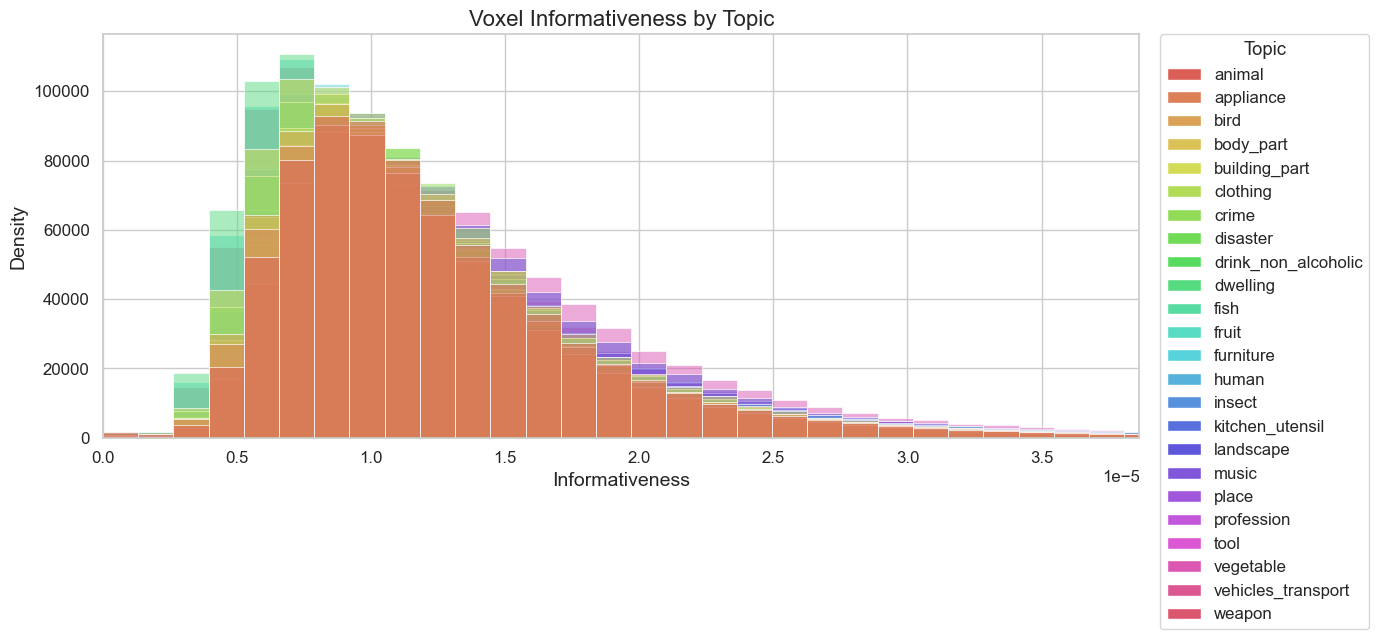

In [42]:
# Plot the scores histogram
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid", font_scale=1.1)

# Set topics palette
unique_topics = sorted(topic_scores['topic'].unique())
palette = sns.color_palette(color_palette, n_colors=len(unique_topics))
topic_colors = dict(zip(unique_topics, palette))

# Create the plot and capture the Axes object
ax = sns.histplot(
    data=topic_scores,
    x="informativeness",
    hue="topic",
    #element="step",
    stat="density",
    common_norm=False,
    palette=palette,
    bins=150
)

plt.title("Voxel Informativeness by Topic", fontsize=16)
plt.xlabel("Informativeness", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.xlim(0, topic_scores['informativeness'].quantile(0.99))


legend_elements = [Patch(facecolor=topic_colors[t], label=t) for t in unique_topics]
plt.legend(
    handles=legend_elements,
    title="Topic",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0,
    ncol=1,
    frameon=True
)

plt.tight_layout()
plt.show()


# Analyze by Network

In [43]:
# Config
metrics = [
"mean_informativeness",
"max_informativeness",
"std_informativeness",
"jsd"]

In [44]:
def load_extract_img(path):
    """
    Load the img file and extract the voxel indices
    :param path: the image path
    :return: the network mask's voxel indices
    """
    img = nib.load(path)
    data = img.get_fdata()
    print("Shape:", data.shape)
    mask = data > 0
    mask_voxel_indices = np.where(mask.flatten())[0]
    return mask_voxel_indices

In [45]:
def analyze_topic_informativeness(topic_scores, mask_voxel_indices, topic_col="topic", top_n=None):
    """
    Computes informativeness statistics (mean, max, std, JSD) within a voxel mask, per topic.
    Optionally limits to the top-N most informative voxels within the mask.

    Parameters:
        topic_scores: DataFrame with 'voxel_index', 'informativeness', and topic column
        mask_voxel_indices: list or array of voxel indices to include
        topic_col: the column name representing topics
        top_n: if set, only the top-N voxels (by mean informativeness) across topics will be used
    :return: DataFrame with aggregated scores for each topic
    """

    # Filter to only voxels within the mask
    filtered = topic_scores[topic_scores["voxel_index"].isin(mask_voxel_indices)]

    if top_n is not None:
        # Compute mean informativeness per voxel
        voxel_means = (
            filtered.groupby("voxel_index")["informativeness"]
            .mean()
            .sort_values(ascending=False)
            .head(top_n)
            .index
        )
        # Keep only rows from top-N voxels
        filtered = filtered[filtered["voxel_index"].isin(voxel_means)]

    # Compute global distribution across all topics (for JSD reference)
    global_dist = (
        filtered.groupby("voxel_index")["informativeness"]
        .mean()
        .reindex(range(filtered["voxel_index"].max() + 1), fill_value=0)
        .values
    )
    global_dist = global_dist / global_dist.sum()

    # Group by topic
    grouped = filtered.groupby(topic_col)
    stats = []

    for topic, group in grouped:
        topic_vals = group.set_index("voxel_index")["informativeness"]

        # Align with global distribution by voxel_index (fill missing with 0)
        aligned = pd.Series(0.0, index=range(len(global_dist)))
        aligned[topic_vals.index] = topic_vals.values

        probs = aligned.values
        probs = probs / probs.sum() if probs.sum() > 0 else probs

        jsd = jensenshannon(probs, global_dist)

        stats.append({
            "topic": topic,
            "mean_informativeness": topic_vals.mean(),
            "max_informativeness": topic_vals.max(),
            "std_informativeness": topic_vals.std(),
            "jsd": jsd
        })

    return pd.DataFrame(stats).sort_values("mean_informativeness", ascending=False)


In [46]:
def plot_metrics(metrics, topic_ranking_df, network_name):
    """
    Create one graph with subplots of different metrics per topic.

    Parameters:
        metrics: list of metric names (e.g., ['f_score', 'r2'])
        topic_ranking_df: DataFrame with topic-level scores per metric
        network_name: name of the network for the main title
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)
    axes = axes.flatten()
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sorted_df = topic_ranking_df.sort_values(metric, ascending=False)
        sns.barplot(
            data=sorted_df,
            x="topic",
            y=metric,
            palette="hls",
            ax=ax
        )
        ax.set_title(metric.replace("_", " ").title(), fontsize=14)
        ax.set_xlabel("Topic")
        ax.set_ylabel("Value")
        ax.tick_params(axis='x', rotation=90)

    fig.suptitle(f"{network_name} Informativeness Scores", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [47]:
def compute_f_score_per_voxel(voxel_matrix, topic_labels, mask_voxel_indices):
    """
    Computes F-score (ANOVA) for each voxel, indicating how well it distinguishes between topics.

    Parameters:
    - voxel_matrix: np.ndarray of shape (n_samples x n_voxels)
    - topic_labels: array-like of shape (n_samples,)
    - mask_voxel_indices: optional list/array of voxel indices to restrict analysis

    Returns:
    - pd.Series: voxel_index → F-score
    """
    # Filter mask to valid indices
    max_idx = voxel_matrix.shape[1]
    mask_voxel_indices = [i for i in mask_voxel_indices if i < max_idx]
    voxel_matrix = voxel_matrix[:, mask_voxel_indices]
    voxel_indices = np.array(mask_voxel_indices)

    f_scores, _ = f_classif(voxel_matrix, topic_labels)
    f_scores = np.nan_to_num(f_scores)

    return pd.Series(f_scores, index=voxel_indices, name="f_score").sort_values(ascending=False)


In [48]:
def agg_and_plot(fmri_data, f_scores, topics_df, color_palette, name):
    """
    Aggregate the F scores per topic and plot the results
    :param fmri_data: fmri data file
    :param f_scores: the f scores computed
    :param topics_df: df containing topic and sentences
    :param color_palette: the color palette
    :param name: the network's name
    :return: none
    """

    # Aggregate the F scores per topic
    topics_df_copy = topics_df.copy()
    sentence_scores = fmri_data[:, f_scores.sort_values(ascending=False).index[:100]]
    sentence_fscore_sum = sentence_scores.sum(axis=1)
    topics_df_copy["f_score_sum"] = sentence_fscore_sum
    topic_fscore_summary = topics_df_copy.groupby("topic_name")["f_score_sum"].mean().sort_values(ascending=False)

    # Plot
    plot_df = topic_fscore_summary.reset_index().rename(columns={"topic_name": "topic", "f_score_sum": "mean_f_score"})

    plt.figure(figsize=(12, 5))
    sns.barplot(data=plot_df, x="topic", y="mean_f_score", palette=color_palette)

    plt.xticks(rotation=45, ha="right")
    plt.ylabel(f"Average Activation")
    plt.xlabel("Topic")
    plt.title(f"Topic-Level Activation Based on Discriminative Voxels in {name} Network", fontsize=14)
    plt.tight_layout()
    plt.show()
    return topic_fscore_summary

## DMN

In [49]:
dmn_mask_voxel_indices = load_extract_img('open_task_data/DMN_overlap_n60.hdr')
dmn_topic_ranking = analyze_topic_informativeness(topic_scores, dmn_mask_voxel_indices, top_n=500)
dmn_topic_ranking.head()


Shape: (79, 95, 69)


,topic,mean_informativeness,max_informativeness,std_informativeness,jsd
21,vegetable,0.000036,0.000167,0.000016,0.085581
16,landscape,0.000034,0.000137,0.000014,0.081767
13,human,0.000034,0.000110,0.000013,0.092802
22,vehicles_transport,0.000033,0.000156,0.000014,0.084179
17,music,0.000032,0.000113,0.000012,0.090248


C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

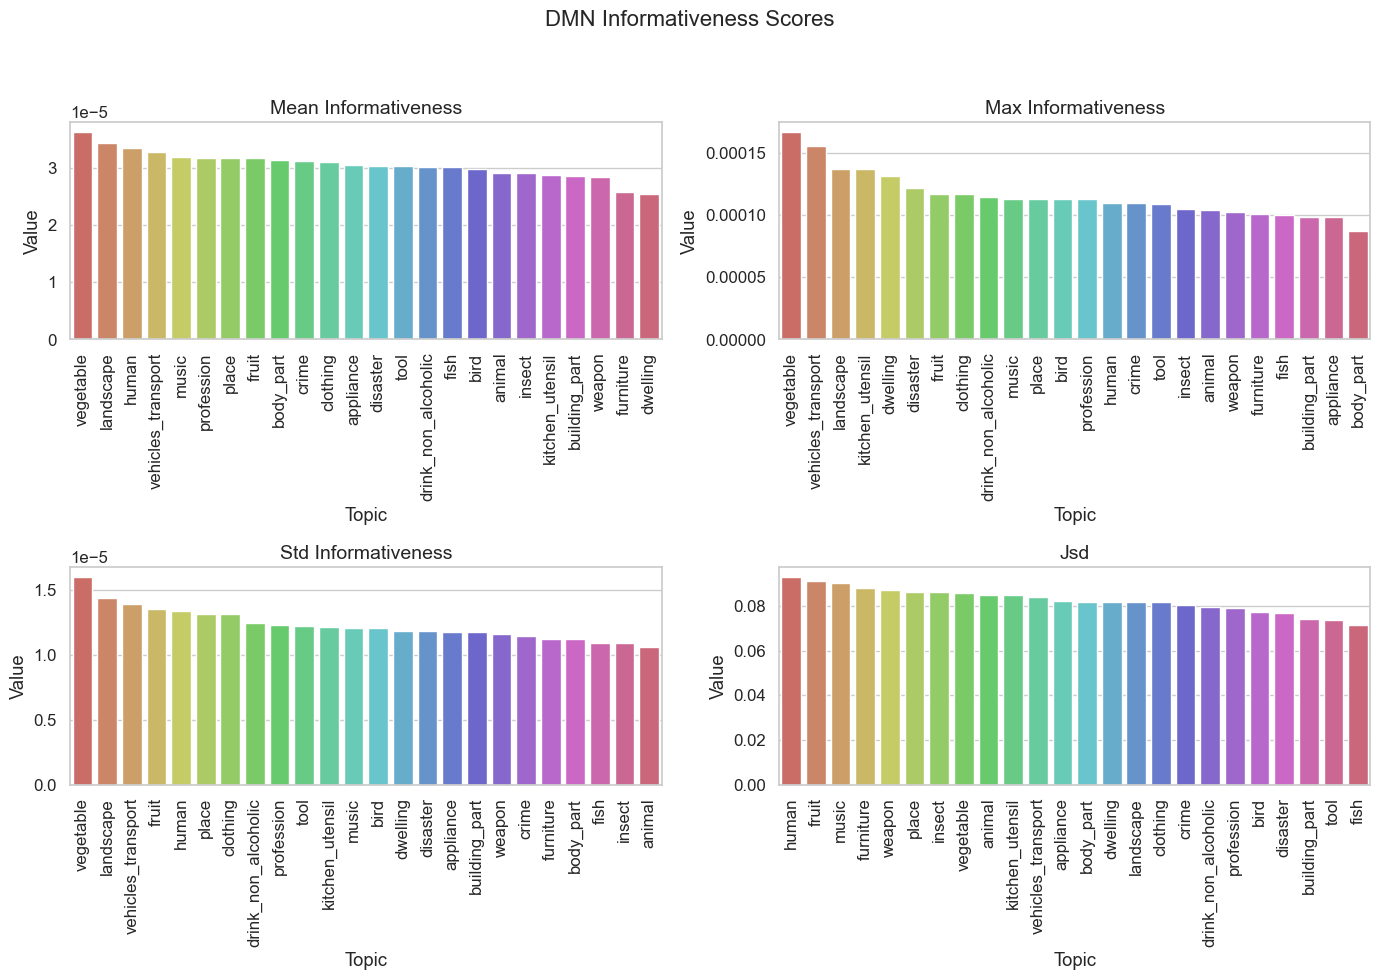

In [50]:
plot_metrics(metrics, dmn_topic_ranking, 'DMN')

In [51]:
len(dmn_mask_voxel_indices)

39163

C:\Users\orosh\OneDrive\Desktop\python projects\second_degree\cognition\final_project\pythonProject\.venv2\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [11772] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\orosh\OneDrive\Desktop\python projects\second_degree\cognition\final_project\pythonProject\.venv2\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\1318897715.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="topic", y="mean_f_score", palette=color_palette)


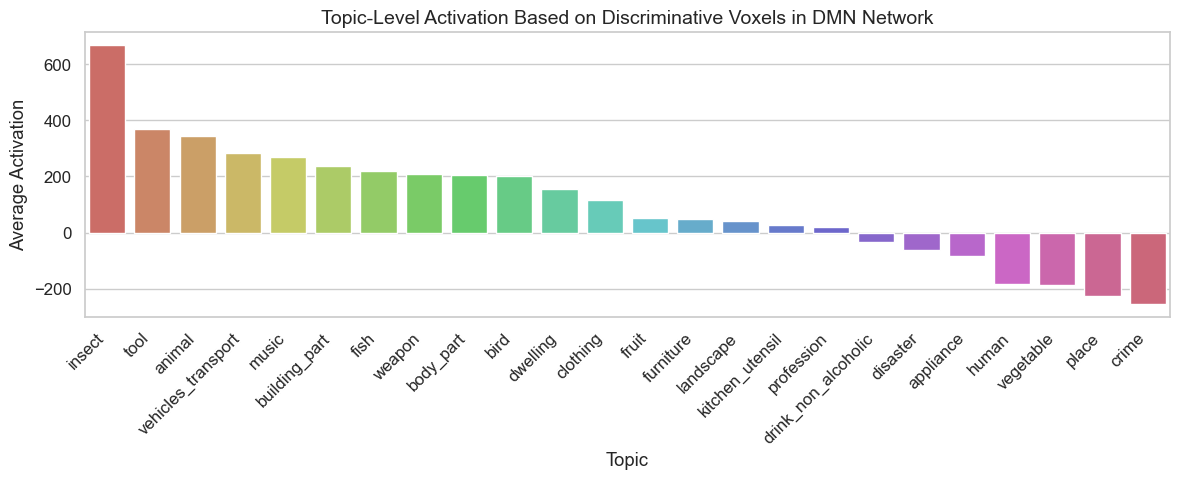

In [52]:
dmn_f_scores = compute_f_score_per_voxel(fmri_data, topics_df["topic_name"].values, dmn_mask_voxel_indices)
dmn_f_scores_by_topic = agg_and_plot(fmri_data, dmn_f_scores, topics_df, color_palette, name='DMN')

## MD

In [53]:
md_mask_voxel_indices = load_extract_img('open_task_data/MD_overlap_n60.hdr')
md_topic_ranking = analyze_topic_informativeness(topic_scores, md_mask_voxel_indices, top_n=500)
md_topic_ranking.head()

Shape: (79, 95, 69)


,topic,mean_informativeness,max_informativeness,std_informativeness,jsd
21,vegetable,0.000037,0.000147,0.000014,0.088552
16,landscape,0.000037,0.000110,0.000012,0.082632
19,profession,0.000035,0.000099,0.000010,0.071607
18,place,0.000034,0.000110,0.000010,0.071125
13,human,0.000034,0.000083,0.000010,0.086693


C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

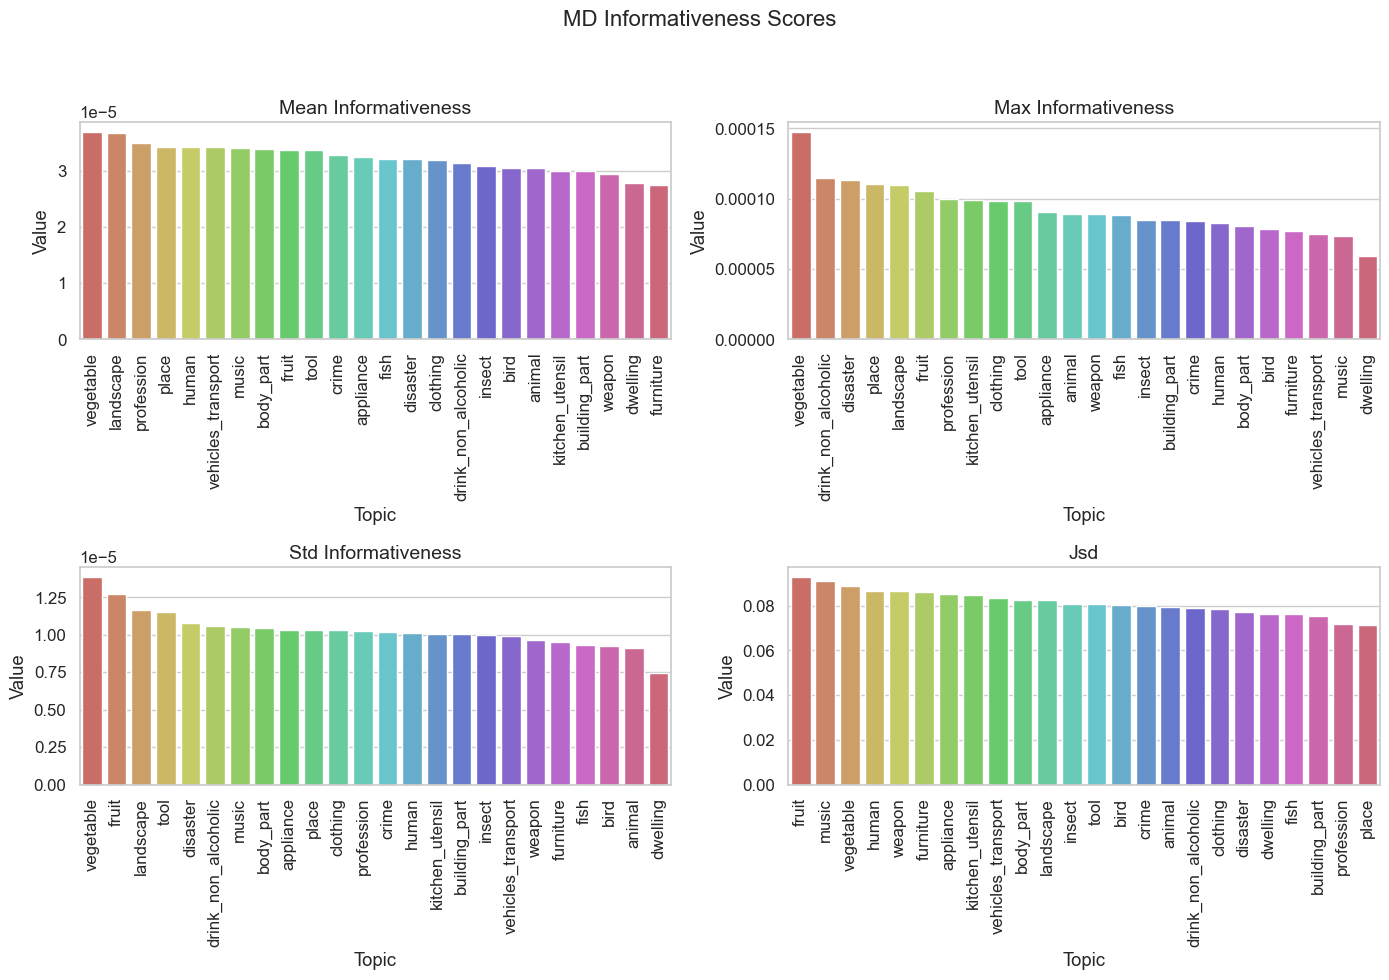

In [54]:
plot_metrics(metrics, md_topic_ranking, 'MD')

C:\Users\orosh\OneDrive\Desktop\python projects\second_degree\cognition\final_project\pythonProject\.venv2\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [26209 26210 26709 26710 26711 26712 27938 27939 27940 28432 28433] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\orosh\OneDrive\Desktop\python projects\second_degree\cognition\final_project\pythonProject\.venv2\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\1318897715.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="topic", y="mean_f_score", palette=color_palette)


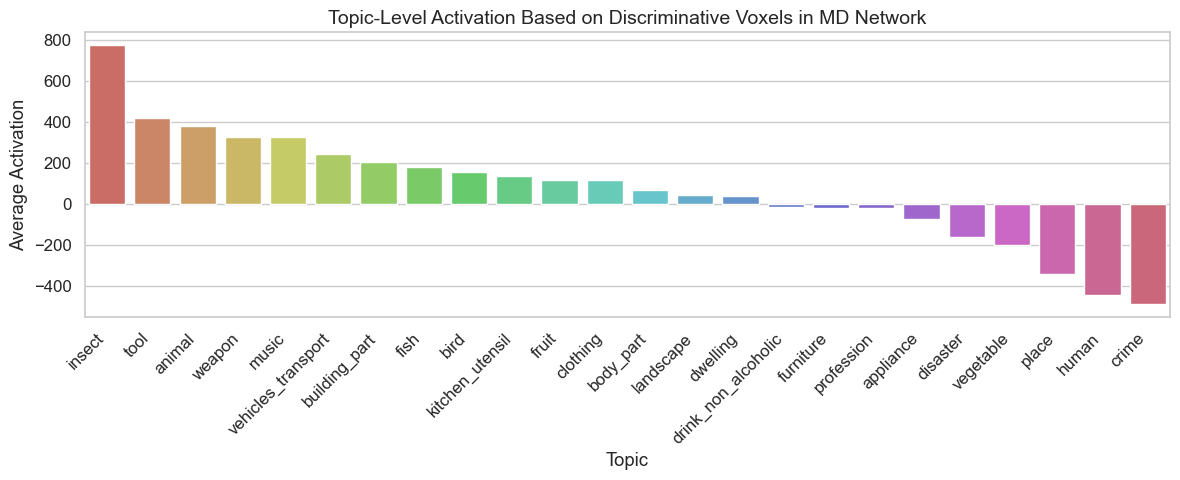

In [55]:
md_f_scores = compute_f_score_per_voxel(fmri_data, topics_df["topic_name"].values, md_mask_voxel_indices)
md_f_scores_by_topic = agg_and_plot(fmri_data, md_f_scores, topics_df, color_palette, name='MD')

## Language

In [56]:
language_mask_voxel_indices = load_extract_img('open_task_data/Language_overlap_n220.hdr')
language_topic_ranking = analyze_topic_informativeness(topic_scores, language_mask_voxel_indices, top_n=500)
language_topic_ranking.head()

Shape: (79, 95, 69)


,topic,mean_informativeness,max_informativeness,std_informativeness,jsd
16,landscape,0.000048,0.000137,0.000017,0.076030
21,vegetable,0.000047,0.000167,0.000019,0.087397
19,profession,0.000045,0.000120,0.000016,0.083182
13,human,0.000044,0.000197,0.000020,0.096036
6,crime,0.000044,0.000182,0.000018,0.078819


C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\2081294152.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

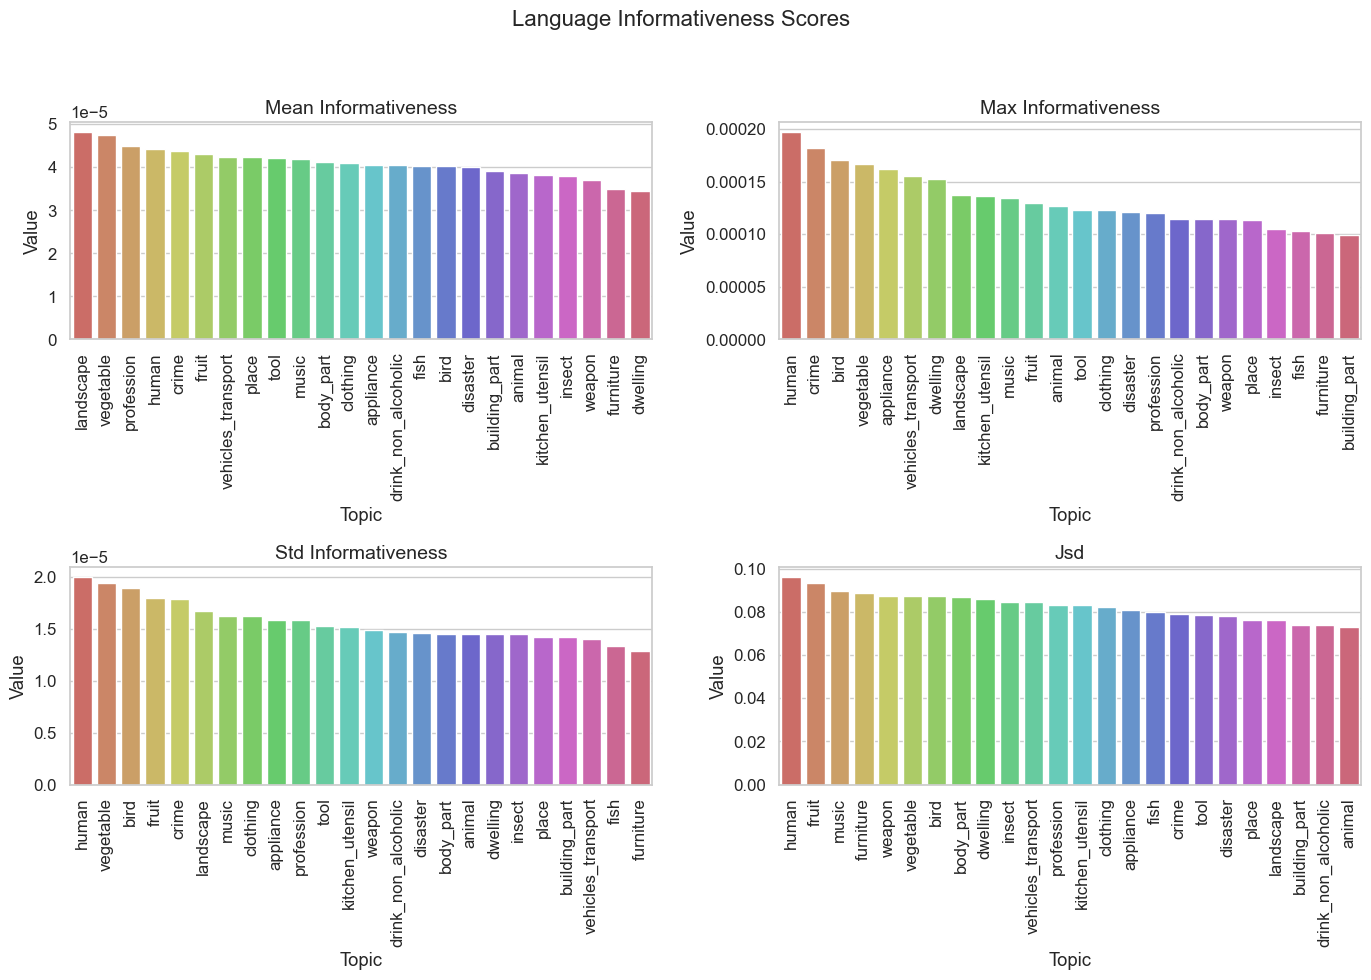

In [57]:
plot_metrics(metrics, language_topic_ranking, 'Language')

C:\Users\orosh\OneDrive\Desktop\python projects\second_degree\cognition\final_project\pythonProject\.venv2\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [45627 46432 46433 46434 46435 46436 46437 46438 46439 46440 46441 46442
 46443 46444 47733 47734 47735 47736 47737 47738 49010 49011 49012 49013
 49014 49015 49016 49017 49018 49019 49020 49021 49022 49023 49031 49032
 49033 49034 49819 49820 49821 49822 49823 49824 49825 49826 49827 49828
 49829 49830 49831 49832 49833 49834 50333 50334] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\orosh\OneDrive\Desktop\python projects\second_degree\cognition\final_project\pythonProject\.venv2\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\1318897715.py:23: FutureWarning: 

Passing `palette` without

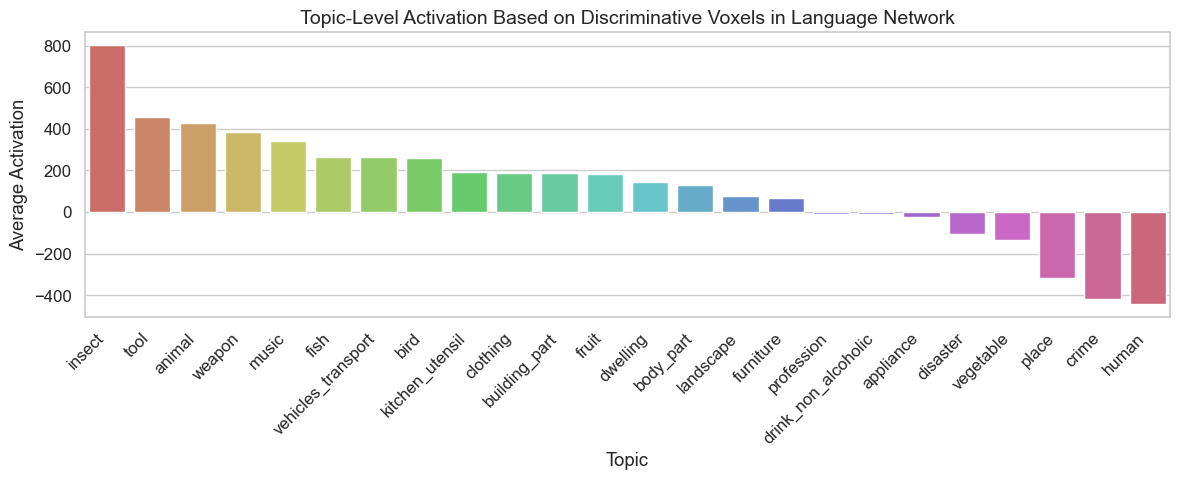

In [58]:
language_f_scores = compute_f_score_per_voxel(fmri_data, topics_df["topic_name"].values, language_mask_voxel_indices)
language_f_scores_by_topic = agg_and_plot(fmri_data, language_f_scores, topics_df, color_palette, name='Language')

# Compare Between Networks

In [59]:
def melt_topic_score_df(df, network_name, score_column="mean_informativeness", topic_col="topic"):
    df = df.copy()
    df["network"] = network_name
    df["score"] = df[score_column]
    return df[[topic_col, "score", "network"]]


## Informative Score

In [60]:
all_scores = pd.concat([
    melt_topic_score_df(dmn_topic_ranking, "DMN"),
    melt_topic_score_df(md_topic_ranking, "MD"),
    melt_topic_score_df(language_topic_ranking, "Language")
])


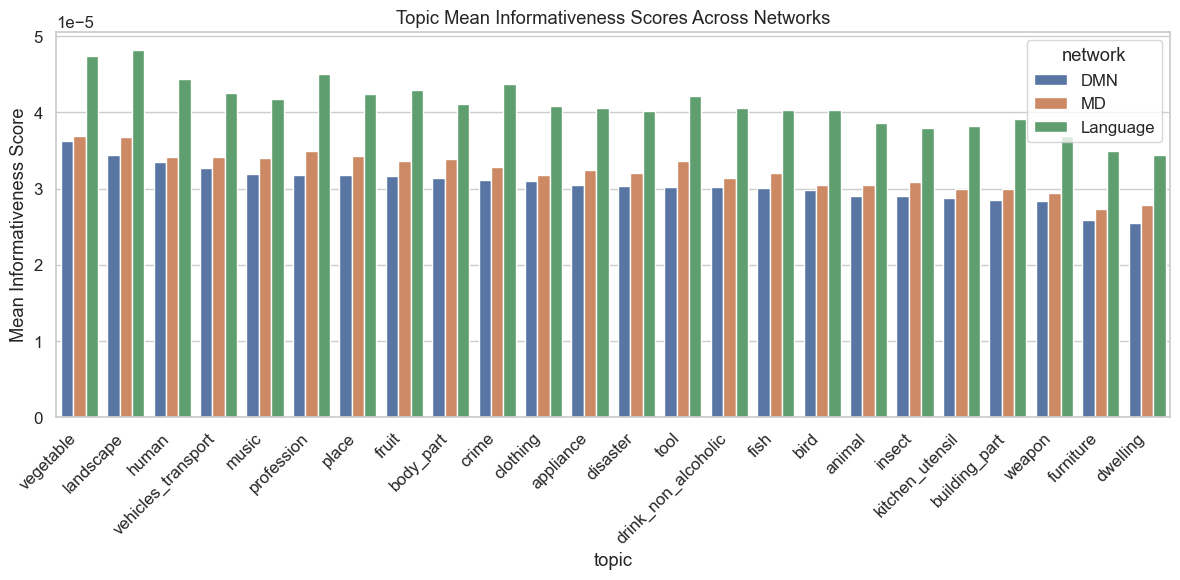

In [61]:
# Compare topics' scores across networks
plt.figure(figsize=(12, 6))
sns.barplot(data=all_scores, x="topic", y="score", hue="network")
plt.xticks(rotation=45, ha="right")
plt.title("Topic Mean Informativeness Scores Across Networks")
plt.ylabel("Mean Informativeness Score")
plt.tight_layout()
plt.show()

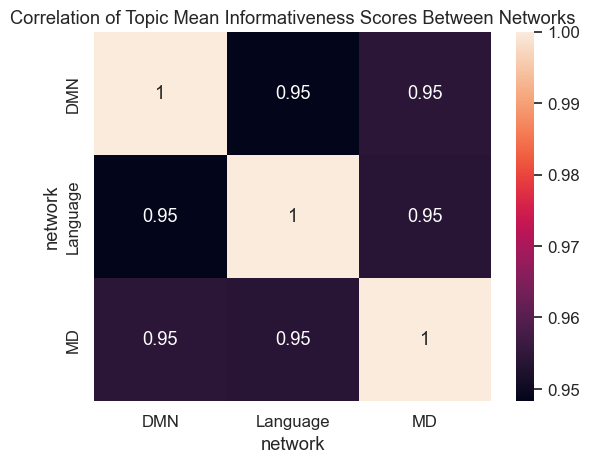

In [62]:
# Correlation between networks
pivot = all_scores.pivot(index="topic", columns="network", values="score")
correlation = pivot.corr(method="pearson")
sns.heatmap(correlation, annot=True)
plt.title("Correlation of Topic Mean Informativeness Scores Between Networks")
plt.show()

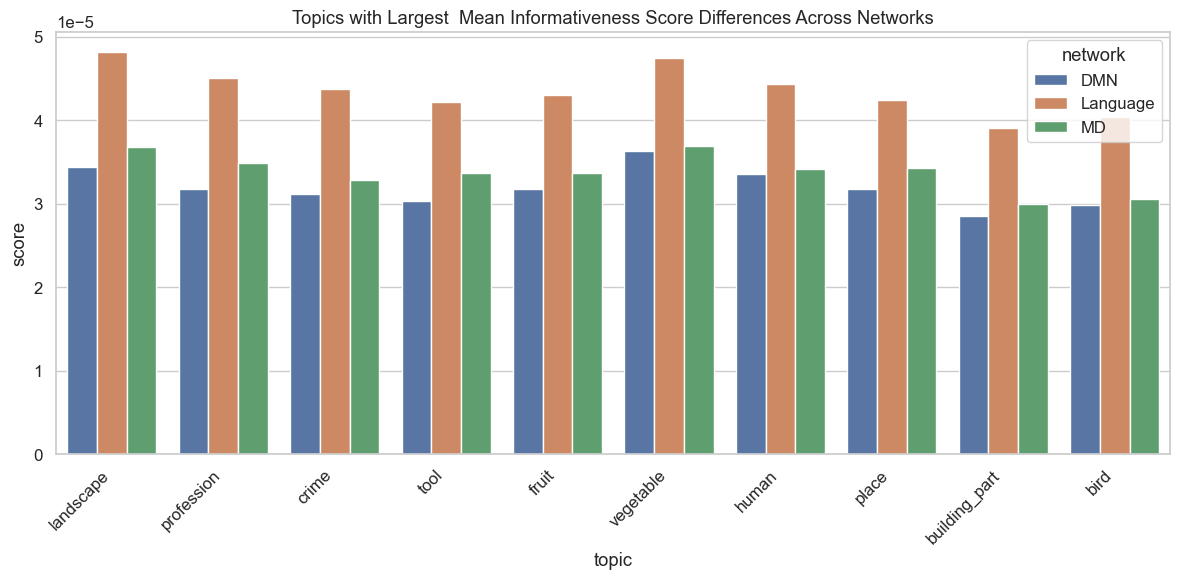

In [63]:
# Find the topics with the largest score difference
pivot["score_range"] = pivot.max(axis=1) - pivot.min(axis=1)
top_diff = pivot.sort_values("score_range", ascending=False).head(10)
top_diff_melted = top_diff.drop(columns="score_range").reset_index().melt(id_vars="topic", var_name="network", value_name="score")

plt.figure(figsize=(12, 6))
sns.barplot(data=top_diff_melted, x="topic", y="score", hue="network")
plt.title("Topics with Largest  Mean Informativeness Score Differences Across Networks")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# F Score

In [64]:
all_f_scores = pd.concat([
    melt_topic_score_df(dmn_f_scores_by_topic.reset_index(), "DMN", "f_score_sum", topic_col="topic_name"),
    melt_topic_score_df(md_f_scores_by_topic.reset_index(), "MD", "f_score_sum", topic_col="topic_name"),
    melt_topic_score_df(language_f_scores_by_topic.reset_index(), "Language", "f_score_sum", topic_col="topic_name")
])


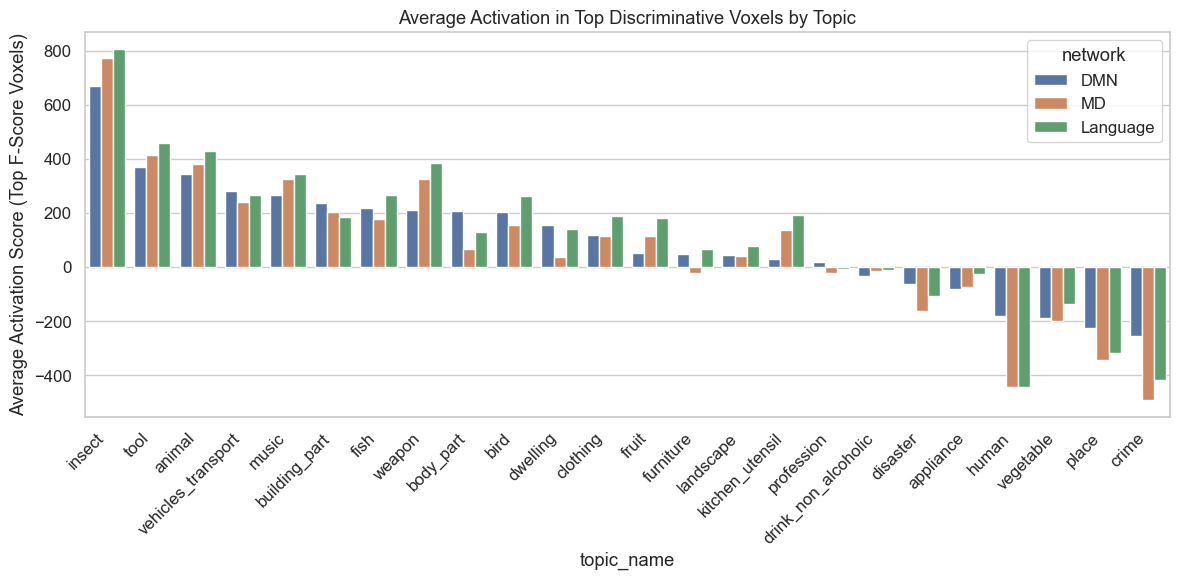

In [65]:
# Compare topics' scores across networks
plt.figure(figsize=(12, 6))
sns.barplot(data=all_f_scores, x="topic_name", y="score", hue="network")
plt.xticks(rotation=45, ha="right")
plt.title("Average Activation in Top Discriminative Voxels by Topic")
plt.ylabel("Average Activation Score (Top F-Score Voxels)")
plt.tight_layout()
plt.show()

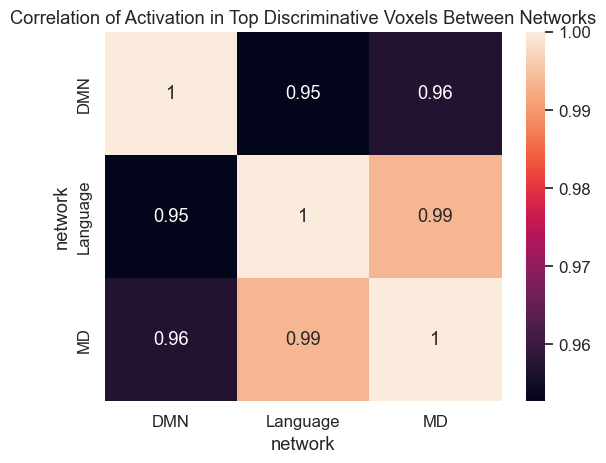

In [66]:
# Correlation between networks
pivot = all_f_scores.pivot(index="topic_name", columns="network", values="score")
correlation = pivot.corr(method="pearson")
sns.heatmap(correlation, annot=True)
plt.title("Correlation of Activation in Top Discriminative Voxels Between Networks")
plt.show()

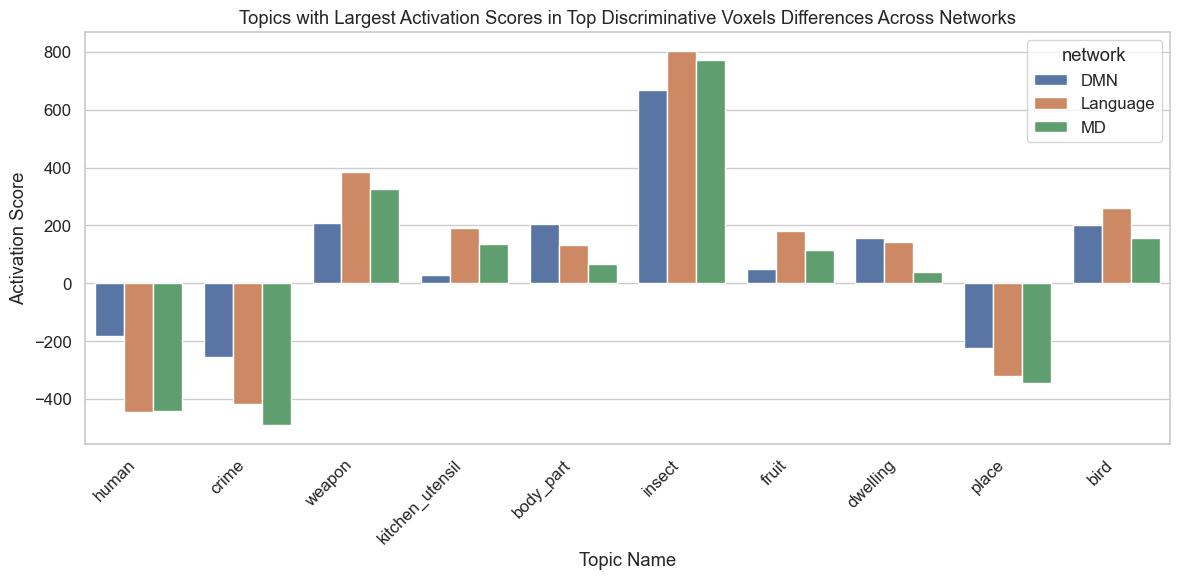

In [67]:
# Find the topics with the largest f-score difference
pivot["score_range"] = pivot.max(axis=1) - pivot.min(axis=1)
top_diff = pivot.sort_values("score_range", ascending=False).head(10)
top_diff_melted = top_diff.drop(columns="score_range").reset_index().melt(id_vars="topic_name", var_name="network", value_name="score")

plt.figure(figsize=(12, 6))
sns.barplot(data=top_diff_melted, x="topic_name", y="score", hue="network")
plt.title("Topics with Largest Activation Scores in Top Discriminative Voxels Differences Across Networks")
plt.xlabel("Topic Name")
plt.ylabel("Activation Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Find Topics Families and Compare Their Scores

In [75]:
topic_embeddings = (
    topics_df.groupby("topic_name")["glove_vector"]
    .apply(lambda vecs: np.mean(list(vecs), axis=0))
)
topic_matrix = np.vstack(topic_embeddings.values)
topic_names = topic_embeddings.index.tolist()
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(topic_matrix)
clustered_topics = pd.DataFrame({
    "topic": topic_names,
    "cluster": labels
}).sort_values("cluster")

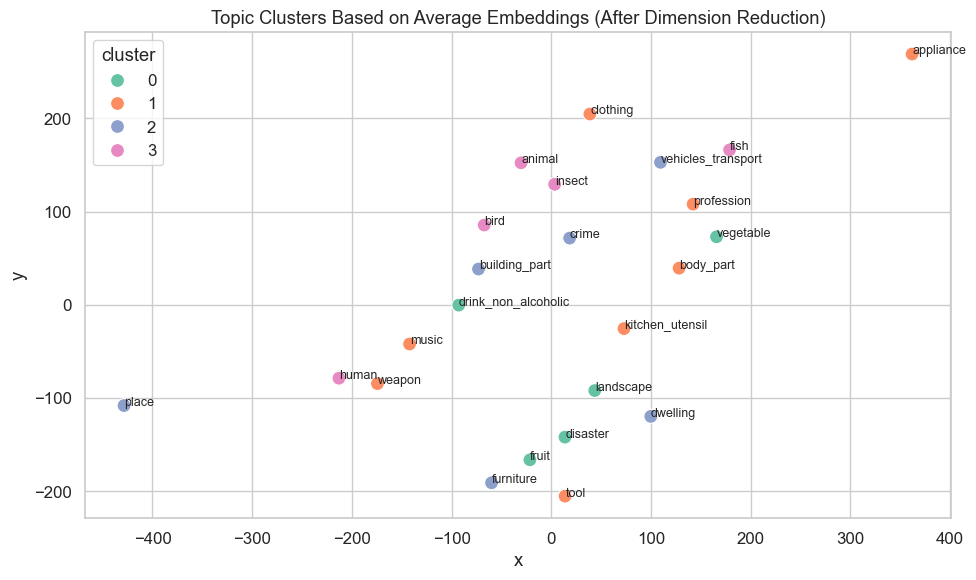

In [85]:
X_2d = TSNE(n_components=2, perplexity=5, random_state=0).fit_transform(topic_matrix)
clustered_topics["x"] = X_2d[:, 0]
clustered_topics["y"] = X_2d[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_topics, x="x", y="y", hue="cluster", palette='Set2', s=100)

for _, row in clustered_topics.iterrows():
    plt.text(row["x"]+0.3, row["y"], row["topic"], fontsize=9)

plt.title("Topic Clusters Based on Average Embeddings (After Dimension Reduction)")
plt.tight_layout()
plt.show()

## Compare F-Scores

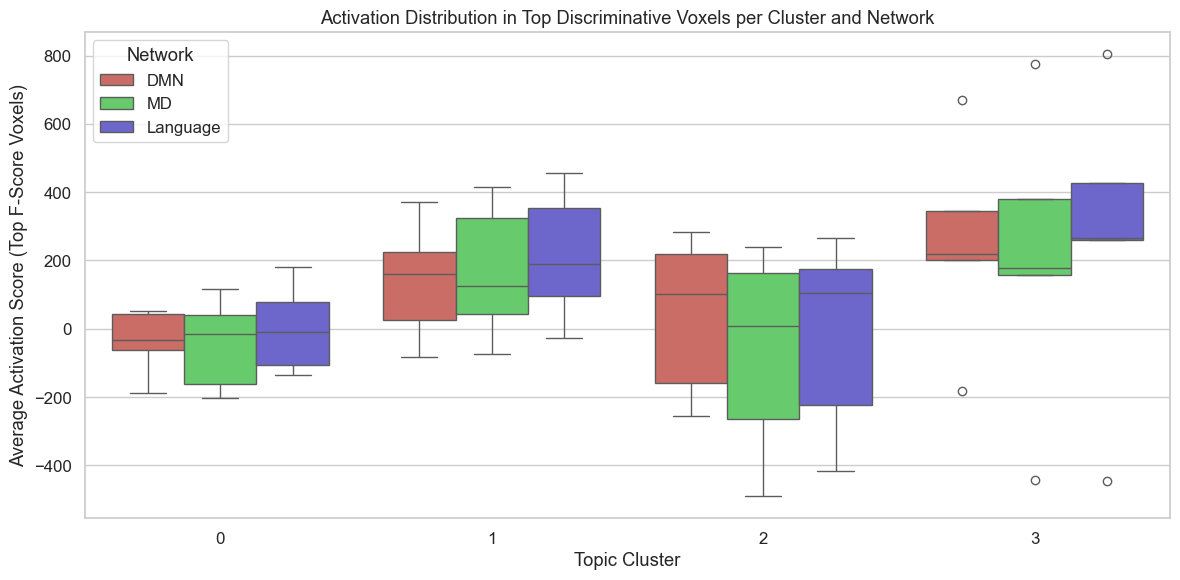

In [77]:
merged = all_f_scores.merge(clustered_topics, left_on="topic_name", right_on="topic")
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged, x="cluster", y="score", hue="network", palette="hls")

plt.title("Activation Distribution in Top Discriminative Voxels per Cluster and Network")
plt.xlabel("Topic Cluster")
plt.ylabel("Average Activation Score (Top F-Score Voxels)")
plt.legend(title="Network")
plt.tight_layout()
plt.show()

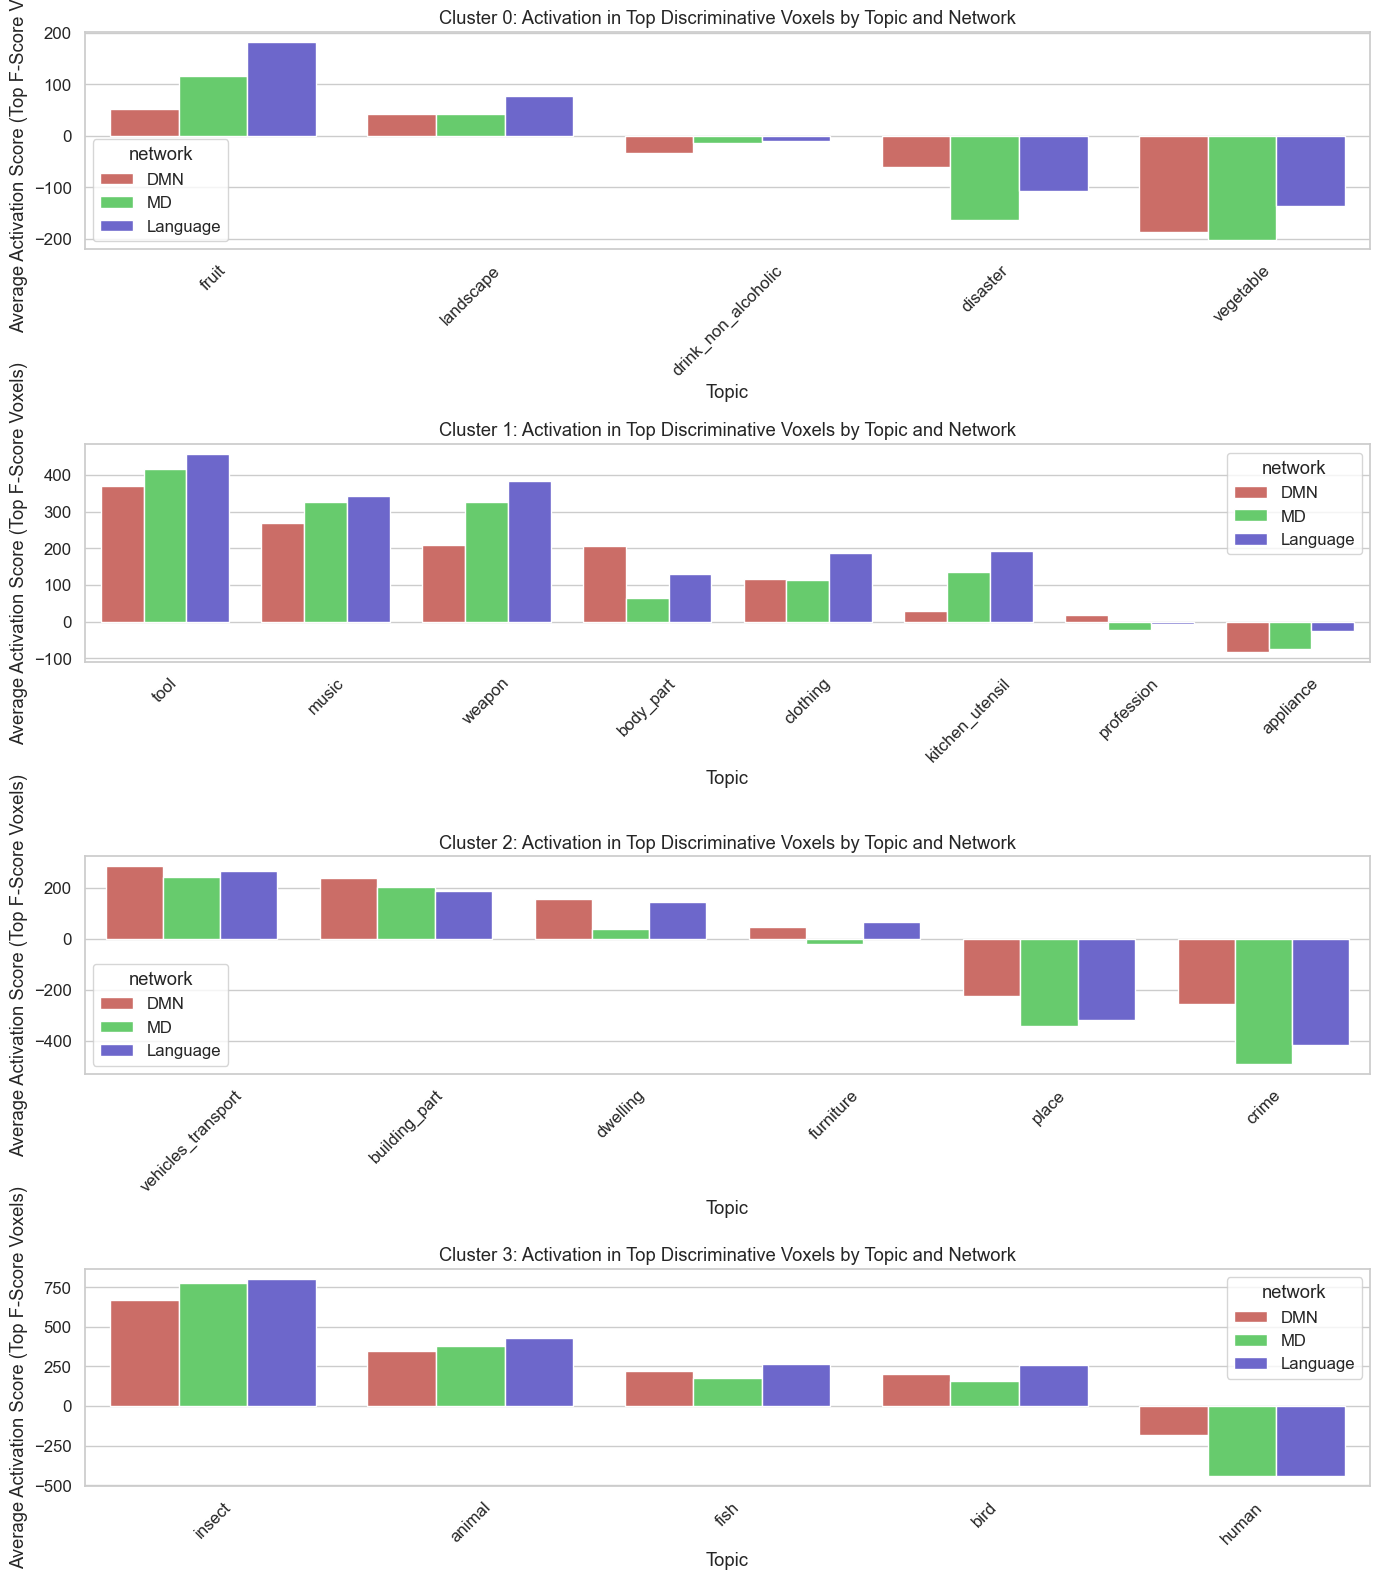

In [78]:
clusters = sorted(merged["cluster"].unique())
num_clusters = len(clusters)

fig, axes = plt.subplots(num_clusters, 1, figsize=(14, 4 * num_clusters), sharex=False)

for i, cluster_id in enumerate(clusters):
    ax = axes[i] if num_clusters > 1 else axes
    cluster_data = merged[merged["cluster"] == cluster_id]

    sns.barplot(
        data=cluster_data,
        x="topic", y="score", hue="network",
        ax=ax, palette="hls"
    )
    ax.set_title(f"Cluster {cluster_id}: Activation in Top Discriminative Voxels by Topic and Network")
    ax.set_ylabel("Average Activation Score (Top F-Score Voxels)")
    ax.set_xlabel("Topic")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Compare Voxels' F-Score per Network

In [79]:
def create_f_score_nii(f_scores_series, original_nii, output_filename):
    """
    Converts a Series of voxel F-scores to a NIfTI image in the original brain space.
    """

    brain_shape = original_nii.shape
    f_map = np.zeros(brain_shape)

    for idx, f_val in zip(f_scores_series.index, f_scores_series.values):
        x, y, z = np.unravel_index(idx, brain_shape)
        f_map[x, y, z] = f_val

    f_nii = nib.Nifti1Image(f_map, affine=original_nii.affine)
    nib.save(f_nii, output_filename)


In [80]:
# Load data
dmn_nii = nib.load("open_task_data/dmn_overlap_n60.hdr")
md_nii = nib.load("open_task_data/MD_overlap_n60.hdr")
language_nii = nib.load("open_task_data/Language_overlap_n220.hdr")

# Create f scores matrix per voxel
create_f_score_nii(dmn_f_scores, dmn_nii, "dmn_f_score_map.nii.gz")
create_f_score_nii(md_f_scores, md_nii, "md_f_score_map.nii.gz")
create_f_score_nii(language_f_scores, language_nii, "language_f_score_map.nii.gz")

C:\Users\orosh\AppData\Local\Temp\ipykernel_18312\4241675058.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


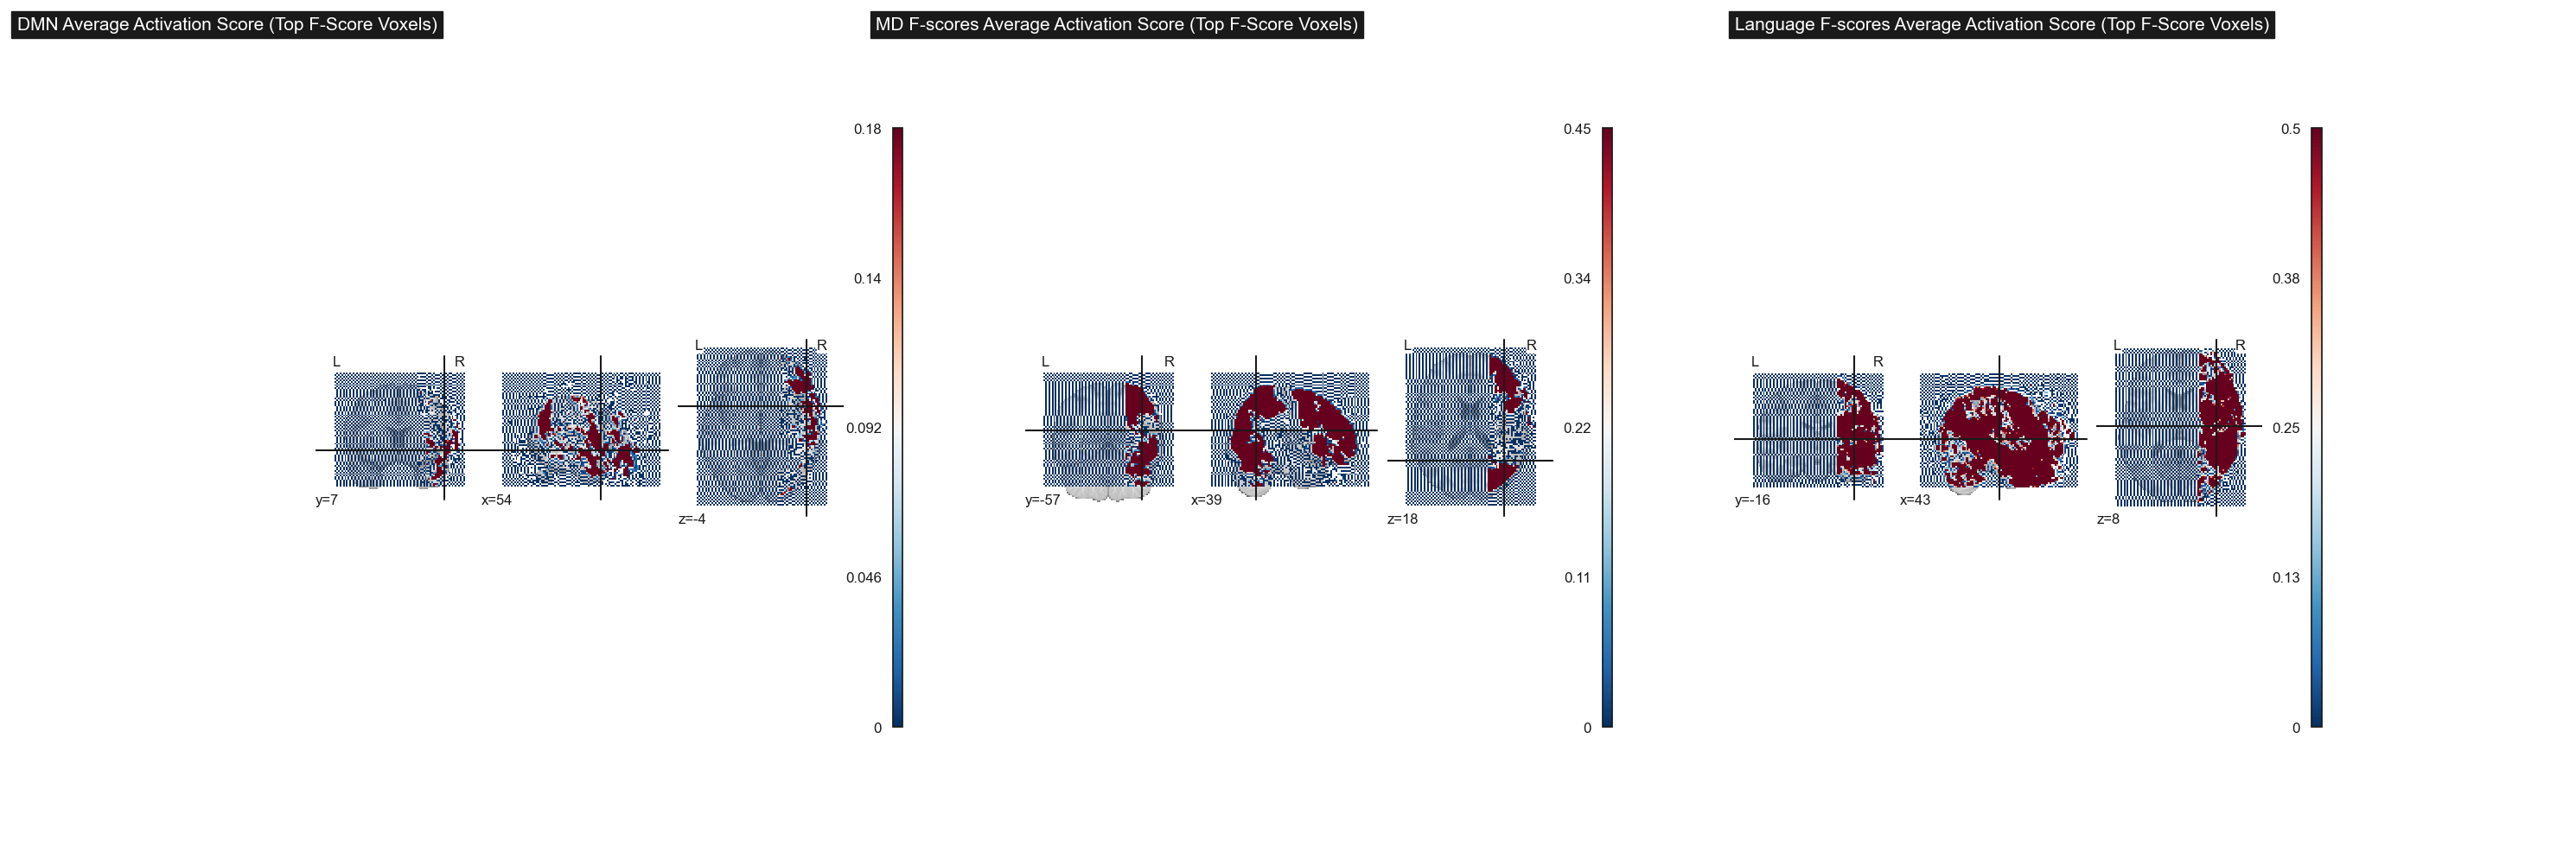

In [83]:
# Plot brain image
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

plotting.plot_stat_map(
    "dmn_f_score_map.nii.gz",
    title="DMN Average Activation Score (Top F-Score Voxels)",
    threshold=0.0, axes=axes[0], colorbar=True, vmax=np.nanmax(dmn_nii.get_fdata())
)
plotting.plot_stat_map(
    "md_f_score_map.nii.gz",
    title="MD F-scores Average Activation Score (Top F-Score Voxels)",
    threshold=0.0, axes=axes[1], colorbar=True, vmax=np.nanmax(md_nii.get_fdata())
)
plotting.plot_stat_map(
    "language_f_score_map.nii.gz",
    title="Language F-scores Average Activation Score (Top F-Score Voxels)",
    threshold=0.0, axes=axes[2], colorbar=True, vmax=np.nanmax(language_nii.get_fdata())
)

plt.tight_layout()
plt.show()


# Concrete VS. Abstract Topics

In [88]:
# Concrete topics: physically perceivable objects or environments
concrete_topics = [
    "animal", "appliance", "bird", "body_part", "building_part", "clothing",
    "drink_non_alcoholic", "dwelling", "fish", "fruit", "furniture", "insect",
    "kitchen_utensil", "landscape", "place", "tool", "vegetable", "vehicles_transport", "weapon"
]

# Abstract topics: concepts not tied to direct physical entities or are socially constructed
abstract_topics = [
    "crime", "disaster", "human", "music", "profession"
]

In [89]:
all_f_scores

,topic_name,score,network
0,insect,669.401420,DMN
1,tool,370.641812,DMN
2,animal,345.288829,DMN
3,vehicles_transport,282.618479,DMN
4,music,268.068688,DMN
...,...,...,...
19,disaster,-107.090727,Language
20,vegetable,-136.604065,Language
21,place,-319.607958,Language
22,crime,-416.911390,Language


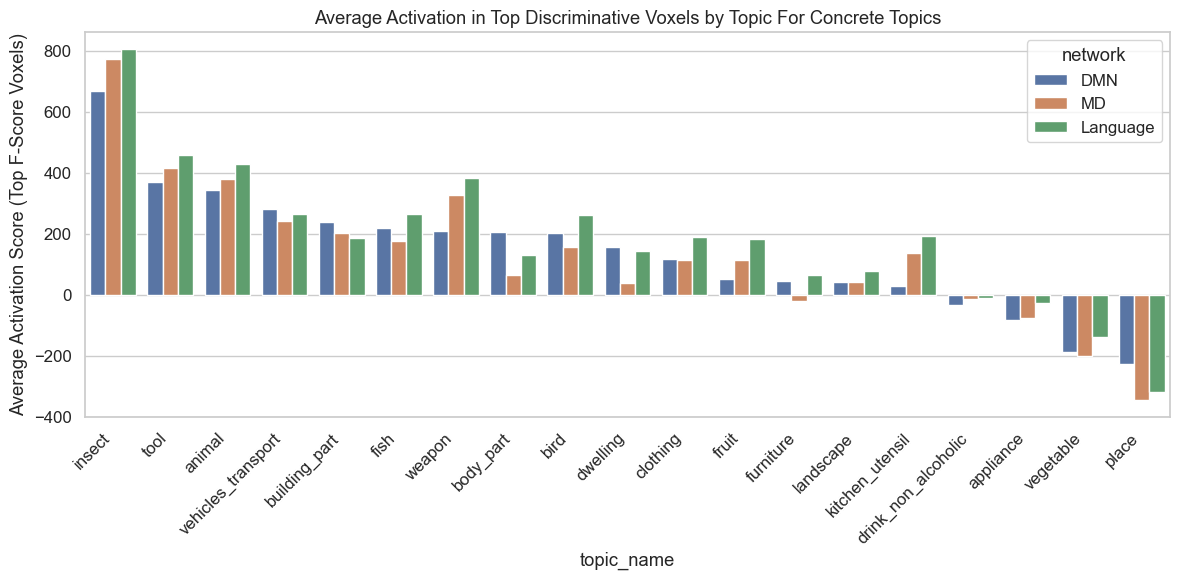

In [90]:
plt.figure(figsize=(12, 6))
sns.barplot(data=all_f_scores[all_f_scores["topic_name"].isin(concrete_topics)], x="topic_name", y="score", hue="network")
plt.xticks(rotation=45, ha="right")
plt.title("Average Activation in Top Discriminative Voxels by Topic For Concrete Topics")
plt.ylabel("Average Activation Score (Top F-Score Voxels)")
plt.tight_layout()
plt.show()

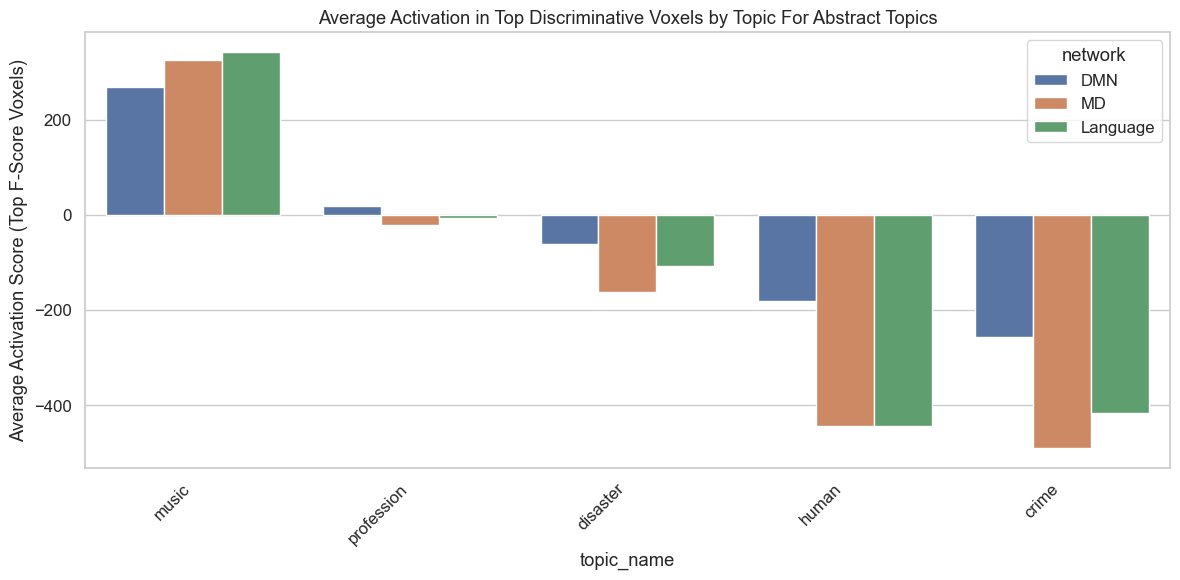

In [91]:
plt.figure(figsize=(12, 6))
sns.barplot(data=all_f_scores[all_f_scores["topic_name"].isin(abstract_topics)], x="topic_name", y="score", hue="network")
plt.xticks(rotation=45, ha="right")
plt.title("Average Activation in Top Discriminative Voxels by Topic For Abstract Topics")
plt.ylabel("Average Activation Score (Top F-Score Voxels)")
plt.tight_layout()
plt.show()